# Code Assignment 19 — Baseline vs. ARIMA on NYC COVID-19 Daily Cases

**Dataset:** NYC DOHMH — *COVID-19 Daily Counts of Cases, Hospitalizations, and Deaths*  
**Target Variable:** `CASE_COUNT`  
**Goal:** Create a **daily** time series, do a **chronological 80/20 split**, run **ADF on differenced time series be sure to use the TRAIN**, then implement a **Baseline model** and **two ARIMA models** and compare **RMSE**.



## Instructor Guidance (some of these steps will be done for you -- look for the "RUN CELL WITHOUT CHANGES" comment)

**Plan**
1) **Load  CSV** → normalize column names; ensure a proper datetime column.  
2) **Select target** `case_count`; coerce to numeric (strip commas).  
3) **Daily index** + **linear interpolation** (fill small gaps).  
4) **Chronological split (80/20)**: first 80% → TRAIN; last 20% → TEST.  
5) **ADF on differenced TRAIN** (provided).  
6) **Student builds**:
   - **Baseline (shift/naïve)** forecast for TEST; compute **RMSE**.  
   - **ARIMA #1**: pick `(p,d,q)`; fit on TRAIN; forecast into TEST; RMSE.  
   - **ARIMA #2**: pick a different `(p,d,q)`; repeat; RMSE.  
7) **Compare RMSEs** and reflect which model beat baseline and by how much.

**Documentation topics to lookup** 
- `statsmodels.tsa.arima.model.ARIMA`  
- `statsmodels.tsa.stattools.adfuller`  
- `sklearn.metrics.mean_squared_error`

### Step 0:  Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")

### Step 1:  Load CSV, Keep Needed Columns, Change time column to a datetime object

In [2]:
df = pd.read_csv("/Users/kabbo/Downloads/covid copy.csv", low_memory=False)

date_col = "date_of_interest"
target_col = "CASE_COUNT"

# Parse date and sort
df[date_col] = pd.to_datetime(df[date_col])
df = df.sort_values(date_col)

# Keep only what we need
df = df[[date_col, target_col]].copy()

df.head()

,date_of_interest,CASE_COUNT
0,2020-02-29,1
1,2020-03-01,0
2,2020-03-02,0
3,2020-03-03,1
4,2020-03-04,5


### Step 2:  Make a daily series for CASE_COUNT (fill tiny gaps linearly)

In [3]:
s = df.set_index(date_col)[target_col].asfreq("D")

s = pd.to_numeric(s.astype(str).str.replace(",", ""))

s = s.astype("float64")
#Do a linear interpolation on the series 
s = s.interpolate(method='linear')

print("Range:", s.index.min().date(), "→", s.index.max().date(), "| Length:", len(s))
s.head()



Range: 2020-02-29 → 2025-10-13 | Length: 2054


date_of_interest
2020-02-29   1.000
2020-03-01   0.000
2020-03-02   0.000
2020-03-03   1.000
2020-03-04   5.000
Freq: D, Name: CASE_COUNT, dtype: float64

### Step 3: Chronological split: first 80% TRAIN, last 20% TEST

Train: 2020-02-29 → 2024-08-28 | n = 1643
Test : 2024-08-29 → 2025-10-13 | n = 411


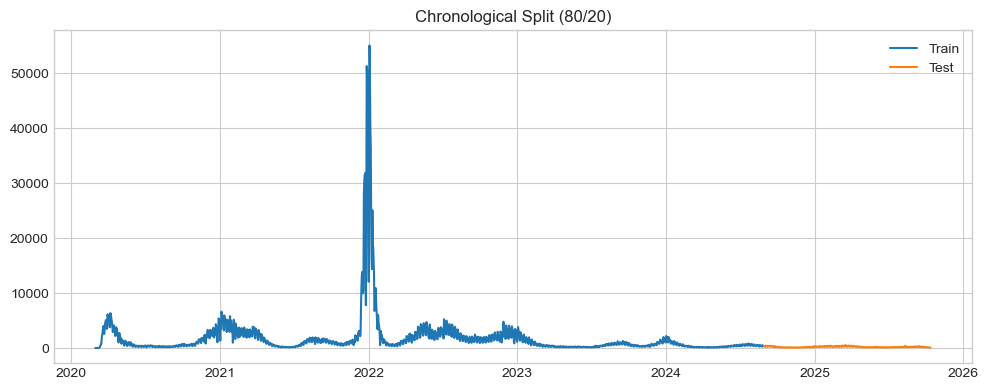

In [4]:
#RUN THIS CELL WITHOUT CHANGES 

split_idx = int(len(s) * 0.80)
train = s.iloc[:split_idx]
test  = s.iloc[split_idx:]

print("Train:", train.index.min().date(), "→", train.index.max().date(), "| n =", len(train))
print("Test :", test.index.min().date(),  "→", test.index.max().date(),  "| n =", len(test))

plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test,  label="Test", color="#ff7f0e")
plt.title("Chronological Split (80/20)")
plt.legend()
plt.tight_layout()
plt.show()

### Step 4:  ADF on DIFFERENCED TRAINING data 

In [5]:
# RUN THIS CELL WITHOUT CHANGES

diff_train = train.diff().dropna()
adf_stat, adf_p, _, _, crit, _ = adfuller(diff_train)

print(f"ADF on differenced TRAIN: stat={adf_stat:.3f}, p={adf_p:.4f}")
for k, v in crit.items():
    print(f"  critical {k}: {v:.3f}")
print("\nIf p < 0.05, using d=1 in ARIMA is reasonable.")

ADF on differenced TRAIN: stat=-9.677, p=0.0000
  critical 1%: -3.434
  critical 5%: -2.863
  critical 10%: -2.568

If p < 0.05, using d=1 in ARIMA is reasonable.


### Step 5:  Create a baseline shift model (use a shift of 1) and calculate the RMSE

- Plot the model (Actual vs. Prediction)

Baseline RMSE: 63.246


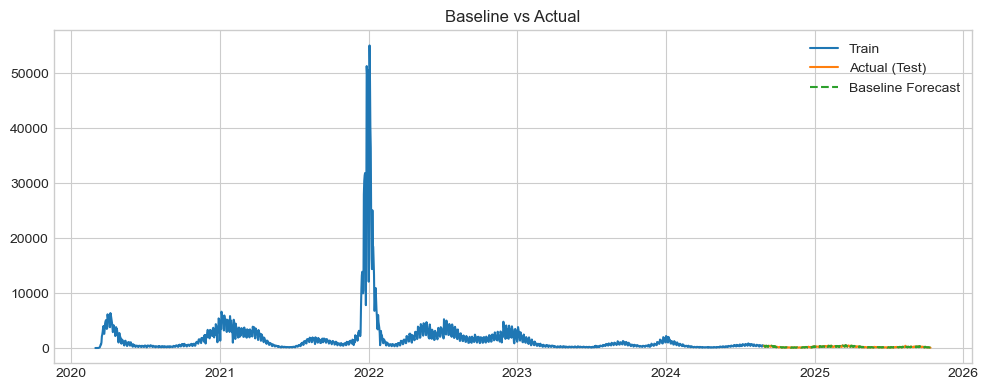

In [7]:
baseline_pred = test.shift(1).fillna(train.iloc[-1])
rmse_baseline = np.sqrt(mean_squared_error(test, baseline_pred))

print(f"Baseline RMSE: {rmse_baseline:,.3f}")

plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test, label="Actual (Test)", color="#ff7f0e")
plt.plot(baseline_pred, label="Baseline Forecast", color="#2ca02c", linestyle="--")
plt.title("Baseline vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

### Step 6:  Create an ARIMA (1,1,1) model:  Fit on TRAIN, forecast into TEST, calculate RMSE
- Plot the visual of the model

ARIMA(1,1,1) RMSE: 261.128


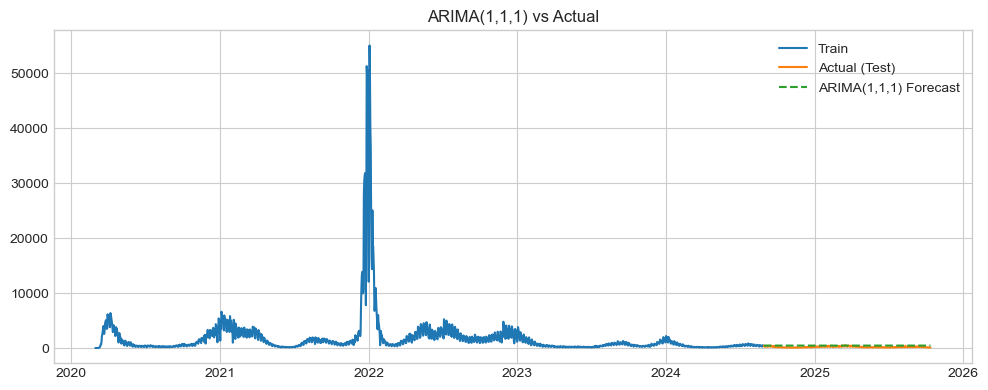

In [8]:
# Fit model on TRAIN
model_111 = ARIMA(train, order=(1,1,1))
fit_111 = model_111.fit()

# Forecast into TEST horizon
forecast_111 = fit_111.forecast(steps=len(test))

# RMSE
rmse_111 = np.sqrt(mean_squared_error(test, forecast_111))
print(f"ARIMA(1,1,1) RMSE: {rmse_111:,.3f}")

# Plot
plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test, label="Actual (Test)", color="#ff7f0e")
plt.plot(forecast_111, label="ARIMA(1,1,1) Forecast", color="#2ca02c", linestyle="--")
plt.title("ARIMA(1,1,1) vs Actual")
plt.legend()
plt.tight_layout()
plt.show()


### Step 7:  Create an ARIMA(2,1,1):  Fit on TRAIN, forecast into TEST, calculate RMSE
- Plot the visual of the model

ARIMA(2,1,1) RMSE: 220.662


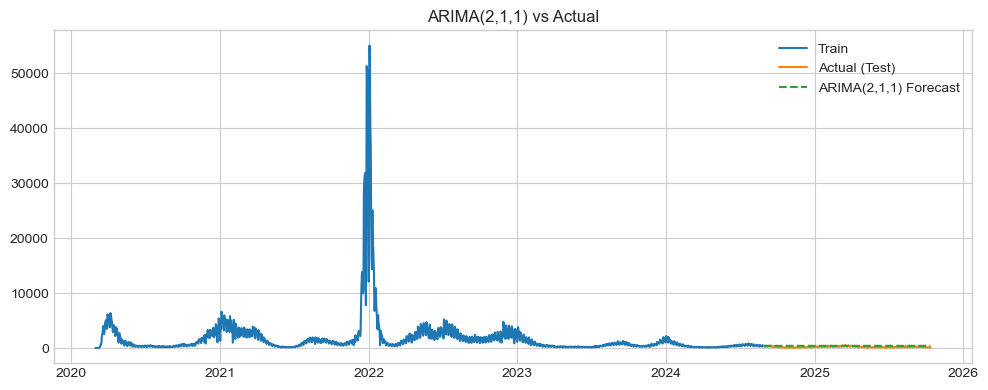

In [9]:
# Fit model on TRAIN
model_211 = ARIMA(train, order=(2,1,1))
fit_211 = model_211.fit()

# Forecast into TEST horizon
forecast_211 = fit_211.forecast(steps=len(test))

# RMSE
rmse_211 = np.sqrt(mean_squared_error(test, forecast_211))
print(f"ARIMA(2,1,1) RMSE: {rmse_211:,.3f}")

# Plot
plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test, label="Actual (Test)", color="#ff7f0e")
plt.plot(forecast_211, label="ARIMA(2,1,1) Forecast", color="#2ca02c", linestyle="--")
plt.title("ARIMA(2,1,1) vs Actual")
plt.legend()
plt.tight_layout()
plt.show()


## Reflection (We Share)
- Which ARIMA order performed best vs. baseline? By how much (%) did it reduce RMSE?
        
        The baseline shift model performed the best with am RMSE of 63.246. Both ARIMA models performed worse than the baseline model. 
            - ARIMA(1,1,1) had an RMSE of 261.128
            - ARIMA(2,1,1) had an RMSE of 220.662
- If neither ARIMA beat baseline, what’s your next step (different d, seasonal naïve, SARIMA, widen training window, handle outliers)?
        
        I would adjust or remote extreme outliers, try SARIMA model, and train on post 2022 data to avoid the huge spike which would be an outlier also.